# Warehouse Robot on a Slippery Floor

<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Create and Inspect](#create_and_inspect)
1. [Q-Learning Implementation](#q_learning_implementation)
1. [Training Q-Learning Agent](#q_learning_training)
1. [Evaluation](#evaluation)
1. [Optimization](#optimization)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [6]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


<a class="anchor" id="import_libraries"></a>
# Import libraries

In [3]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output
import time
import networkx as nx
from gymnasium.envs.toy_text.frozen_lake import MAPS as FROZEN_LAKE_MAPS
import seaborn as sns
from tabulate import tabulate
import itertools
import math

<a class='anchor' id='create_and_inspect'></a>
# Create and Inspect

In [182]:
'''function to initialize the FrozenLake environment with parameters in order to avoid early termination it is added parameter max_episode_steps set to 1000 by default'''
def get_env(env_name: str="FrozenLake-v1", map_name: str="4x4", is_slippery: bool=True, render_mode: str="rgb_array", max_episode_steps: int = 1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=is_slippery, render_mode=render_mode, max_episode_steps=max_episode_steps)
    return env

env = get_env("FrozenLake-v1", "4x4", True, "ansi") # when slippery is True, the agent may not move in the intended direction add randomness to the environment

# basic info
env.reset()
print(env.render())
print("Action space size:", env.action_space.n)
print("Observation space size:", env.observation_space.n)


SFFF
FHFH
FFFH
HFFG

Action space size: 4
Observation space size: 16


Gym environment have built-in reward system were:
- Move to a Frozen tile(F) give 0 reward
- Fall into a Hole(H) give 0 reward and end the episode
- Reaching the Goal(G) give reward 1 and end the episode

[0]

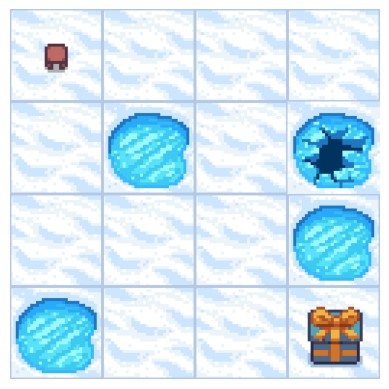

In [5]:
# Test and Visualize a random policy(random_movement) and heuristic policy(heuristic_movement were the agent tries to move right until the edge and down towards the goal)
def run_random_episodes(env: gym.Env, visualize: bool = True, episodes: int = 30):# episodes are the number of tries for the robot to reach the goal
    success_flags = []
    for episode in range(episodes):
        state, info = env.reset() # reset the environment and get the initial state
        done = False
        number_of_steps = 0
        while not done:
            action = env.action_space.sample()  # Take a random action, action is an integer representing the action taken by the agent. In FrozenLake, there are four possible actions: 0 (left), 1 (down), 2 (right), and 3 (up).
            state, reward, done, truncated, info = env.step(action)
            '''state: is an integer representing the agent's current position on the grid. in a 4x4 grid, the states are numbered from 0 to 15, starting from the top-left corner (0) to the bottom-right corner (15).
               reward: is a float value that indicates the immediate reward received after taking the action. In FrozenLake, the reward is typically 0 for most transitions, except when the agent reaches the goal state, where it receives a reward of 1.
               done: is a boolean flag that indicates whether the episode has ended. An episode ends when the agent reaches a terminal state, such as falling into a hole or reaching the goal.
               truncated: is a boolean flag that indicates whether the episode was truncated due to reaching the maximum number of steps allowed in the environment.
               info: is a dictionary that may contain additional information about the environment's state or the action taken.'''
            number_of_steps += 1
            if visualize: # visualize the robot's movement to see how it explores the environment
                animation_speed = 0.5  # seconds between frames
                plt.ion()
                img = env.render()
                plt.imshow(img)
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                time.sleep(animation_speed)
                if done or number_of_steps >= 30:
                    clear_output(wait=False)
                    plt.ioff()
                    break
    
        success_flags.append(reward)
        
    return success_flags, number_of_steps
        

def run_heuristic_episodes(env: gym.Env, visualize: bool = True, episodes: int = 30):
    success_flags = []
    for episode in range(episodes):
        state, info = env.reset()
        done = False
        while not done:
            # Heuristic: Move right if possible, else move down
            row = state // int(np.sqrt(env.observation_space.n))
            col = state % int(np.sqrt(env.observation_space.n))

            if col < np.sqrt(env.observation_space.n) - 1:
                        action = 2  # right
            else:
                        action = 1  # down

            state, reward, done, truncated, info = env.step(int(action))
            if visualize:
                    animation_speed = 0.5  # seconds between frames
                    plt.ion()
                    img = env.render()
                    plt.imshow(img)
                    plt.axis('off')
                    clear_output(wait=True)
                    display(plt.gcf())
                    time.sleep(animation_speed)
                    if done:
                        clear_output(wait=False)
                        plt.ioff()
                        break
        success_flags.append(reward)
    return success_flags

env = get_env("FrozenLake-v1", "4x4", True, "rgb_array", max_episode_steps=100) # make it rgb_array for visualization
run_random_episodes(env, visualize=True, episodes=1)
time.sleep(2)
run_heuristic_episodes(env, visualize=True, episodes=1)

Because the environment is stochastic (slippery) the robot was not moving to the right and down as intended all the time.

In [6]:
def action_transitions(env, state, action_name="Right"):
    '''this function shows the possible transitions from a given state when taking a specific action in the FrozenLake environment.'''
    action_map = {"Left": 0, "Down": 1, "Right": 2, "Up": 3}
    a = action_map[action_name]
    env_raw = env.unwrapped

    print(f"\nFrom state {state}, if you try to move {action_name.lower()}:")
    transitions = env_raw.P[state][a]
    for prob, next_state, reward, done in transitions:
        if prob > 0:
            print(f"  - {prob*100:.1f}% chance of moving to state {next_state} "f"(reward={reward}, done={done})") if state != next_state else print(f"  - {prob*100:.1f}% chance of staying in state {state} "f"(reward={reward}, done={done})")   
action_transitions(env, state=0, action_name="Right")
action_transitions(env, state=6, action_name="Down")


From state 0, if you try to move right:
  - 33.3% chance of moving to state 4 (reward=0, done=False)
  - 33.3% chance of moving to state 1 (reward=0, done=False)
  - 33.3% chance of staying in state 0 (reward=0, done=False)

From state 6, if you try to move down:
  - 33.3% chance of moving to state 5 (reward=0, done=True)
  - 33.3% chance of moving to state 10 (reward=0, done=False)
  - 33.3% chance of moving to state 7 (reward=0, done=True)


The output above demonstrates the **stochastic (slippery)** nature of the FrozenLake environment. When the agent attempts to move in a direction, there's uncertainty in the actual outcome:

**Three possible outcomes per action**: Each action results in one of three possibilities:
-   Move in the **intended direction** (33.3%)
-   Move **perpendicular left(or stay in the same state if that is not possible)** to the intended direction (33.3%)
-   Move **perpendicular right(or stay in the same state if that is not possible)** to the intended direction (33.3%)

This stochasticity makes the environment challenging, as the agent cannot rely on deterministic movements and must learn a robust policy that accounts for these uncertainties.

<a class="anchor" id="q_learning_implementation"></a>
# Q-Learning Implementation

In [7]:
# intialize the Q-table
'''Q- learning table example
State | Left   Down   Right   Up
--------------------------------
0     | 0.12   0.05   0.22    0.00
1     | 0.00   0.03   0.18    0.04
from each state the robot takes an action with the highest Q-value
''' 
n_states = env.observation_space.n
n_actions = env.action_space.n

Q_table = np.zeros((n_states, n_actions))
print("Q table shape:")
print(Q_table.shape)



Q table shape:
(16, 4)


In [8]:
# define ε-greedy action policy
def epsilon_greedy_policy(Q, state, epsilon):
    '''this function implements the ε-greedy policy for action selection in Q-learning.
    it gives the robot chance to explore and learn the environment'''
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the action with max value (greedy)

In [9]:
def epsilon_decay_normal(initial_epsilon: float, min_epsilon: float, decay_rate: float): # exponential epsilon decay function
    '''since the robot need to stick to its learned policy over time, this function exponentially reduces the 
    exploration rate (epsilon)'''
    return max(min_epsilon, initial_epsilon * decay_rate)

'''there are also aternative epsilon decay functions we will use for expermenting and will be writen down here'''
# linear way 
def epsilon_linear_decay(t, total_episodes, epsilon_initial, epsilon_min):
    '''Linear decay of epsilon over 80% of training'''
    stop = int(0.8*total_episodes)
    if t > stop:
        return epsilon_min
    return epsilon_initial -(epsilon_initial-epsilon_min)*(t/stop)

# Inverse decay
def epsilon_inverse_decay(episode: int, epsilon_initial: float, epsilon_min: float, k: float=0.001):
    return max(epsilon_min, epsilon_initial / (1+k*episode))

# Cosine decay
def epsilon_cosine_decay(episode: int, total_episodes: float, epsilon_initial: float, epsilon_min: float):
    consine_term = (1 + math.cos(math.pi * episode/total_episodes))/2
    return epsilon_min + (epsilon_initial - epsilon_min)*consine_term

# step decay
def epsilon_step_decay(episode: int, step_size: int, epsilon_initial: float, epsilon_min: float, decay_factor: float=0.5):
    steps = episode // step_size
    epsilon = epsilon_initial*(decay_factor**steps)
    return max(epsilon_min, epsilon)

### Q-Learning Update Rule

The Q-learning update rule is defined as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

####  Variable Definitions

- \( Q(s, a) \): Estimated value of taking action \( a \) in state \( s \).
- \( \alpha \): Learning rate (how quickly the agent updates its knowledge).
- \( r \): Reward received after taking action \( a \) in state \( s \).
- \( \gamma \): Discount factor (how much future rewards are valued).
- \( \max_{a'} Q(s', a') \): Maximum estimated value of the next state \( s' \), over all possible actions \( a' \).
- \( s \): Current state.
- \( a \): Action taken in state \( s \).
- \( s' \): Next state after taking action \( a \).
- \( a' \): A possible action in the next state \( s' \).

In [10]:
def q_update(Q: np.ndarray, state: int, action: int, reward: float, next_state: int, alpha: float, gamma: float, done: bool):
    '''Q-learning update rule function based on the formula above'''
    target = reward + gamma * np.max(Q[next_state])*(not done)
    Q[state][action] += alpha * (target - Q[state][action])

<a class="anchor" id="q_learning_training"></a>
# Training Robot with Q-learning
Goal

- Run multiple episodes to train the agent:

- Use the ε-greedy policy from before.

- Add ε decay (less exploration over time).

- Update the Q-table after every step.

- Track episode returns and success rate


In [192]:
def q_learning_training(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False, epsilon_scheduling_type: str = 'normal', early_stopping: bool = True):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0
    total_steps = [] # total steps per episode
    stable_counter = 0 # counter for convergence checking

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            steps += 1
            next_state, reward, done, truncated, info = env.step(action)
            # Q-value update
            q_update(Q, state, action, reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            done = done or truncated
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and reward > 0 else 0)
        total_steps.append(steps)

        # Decay epsilon
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'inverse':
            epsilon = epsilon_inverse_decay(episode, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'cosine':
            epsilon = epsilon_cosine_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'step':
            epsilon = epsilon_step_decay(episode, step_size=1000, epsilon_initial=epsilon_initial, epsilon_min=epsilon_min, decay_factor=0.5)
            


        # check for convergence every 1000 episodes        '''
        if (episode + 1) % 200 == 0 and early_stopping:
            '''check if success rate is stable over the last 3 windows'''
            recent_success_rate = np.mean(success_flags[-1000:])
            previous_success_rate = np.mean(success_flags[-2000:-1000])
            improvement = abs(recent_success_rate - previous_success_rate)
            if improvement < 0.02 and  recent_success_rate > 0:
                stable_counter += 1
            else:
                stable_counter = 0
            
            if stable_counter >= 5:
                print(f"Convergence reached at episode {episode + 1}.")
                break

            
    return Q, rewards, success_flags, total_steps, episode + 1




In [197]:
# train the robot using Q-learning
Q, rewards, success_flags, total_steps, episode = q_learning_training( env, num_episodes=100000,
                                                alpha=0.8,
                                                gamma=0.99,
                                                epsilon=1.0,
                                                epsilon_min=0.01,
                                                epsilon_decay=0.999,
                                                visualize=False,
                                                epsilon_scheduling_type='normal')

# evaluate the trained robot
print(f"Success rate: {np.mean(success_flags)*100:.2f}%")
# print the number of episodes taken to converge
print(f"Number of episodes to converge: {episode}")

Convergence reached at episode 12200.
Success rate: 43.04%
Number of episodes to converge: 12200


<a class="anchor" id="evaluation"></a>
# Evaluation

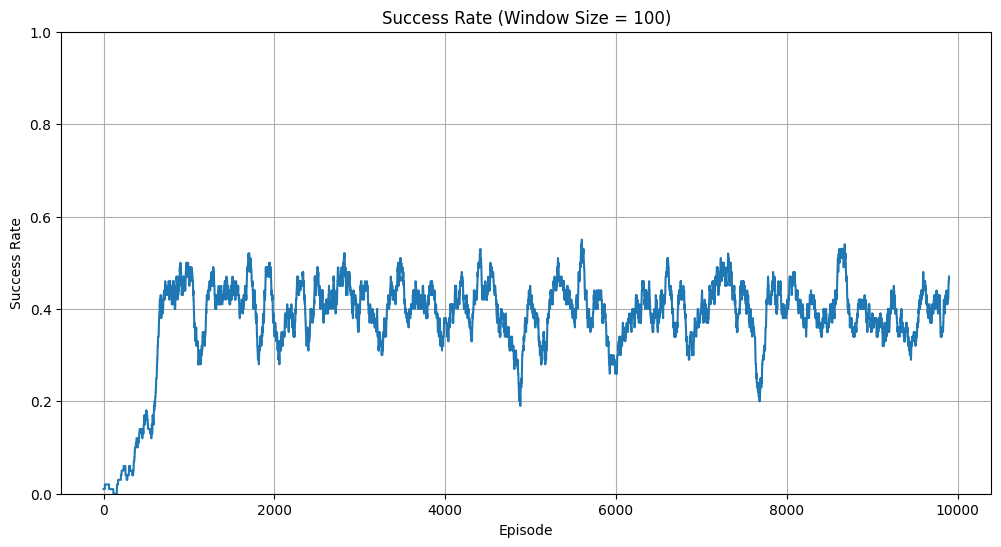

success_rate: 0.3797


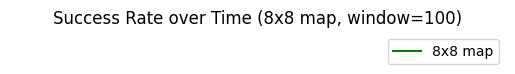

Final Success Rate (8x8 map): 0.50


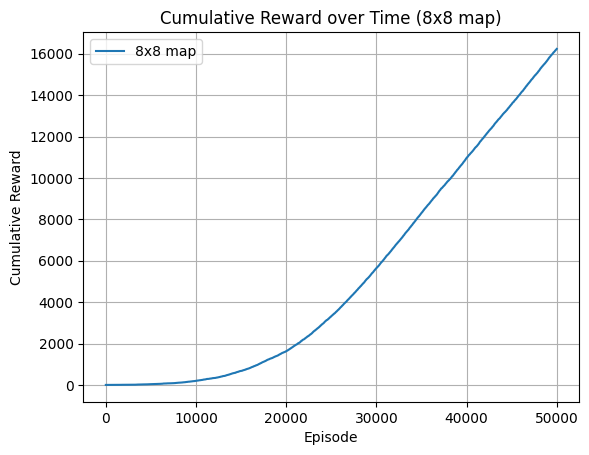

Final Cumulative Reward (8x8 map): 16231.00


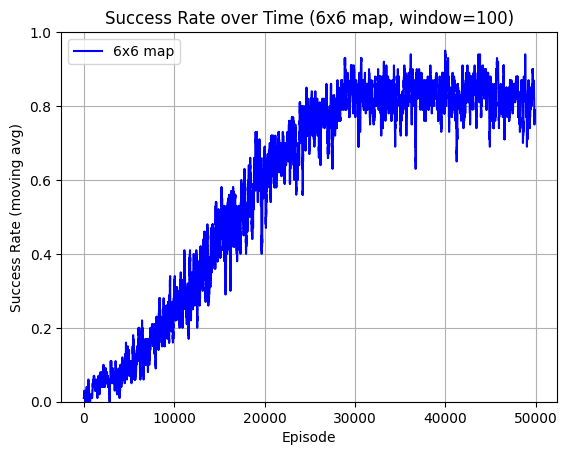

Final Success Rate (6x6 map): 0.77


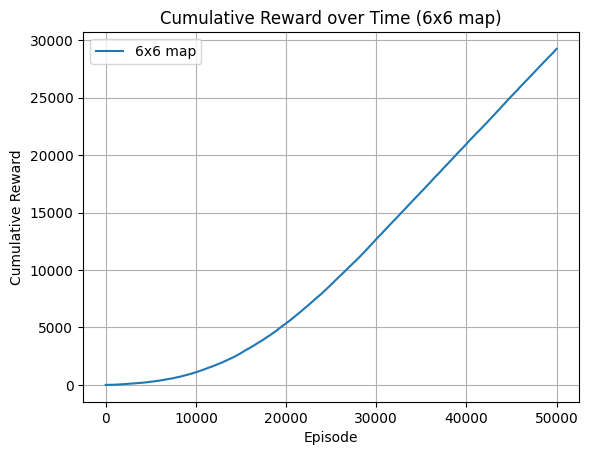

Final Cumulative Reward (6x6 map): 29232.00


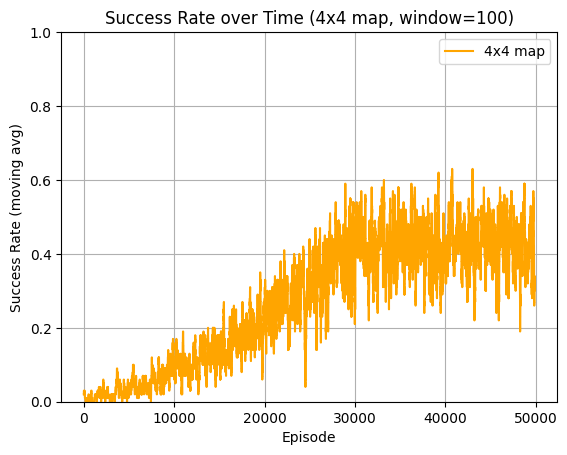

Final Success Rate (4x4 map): 0.31


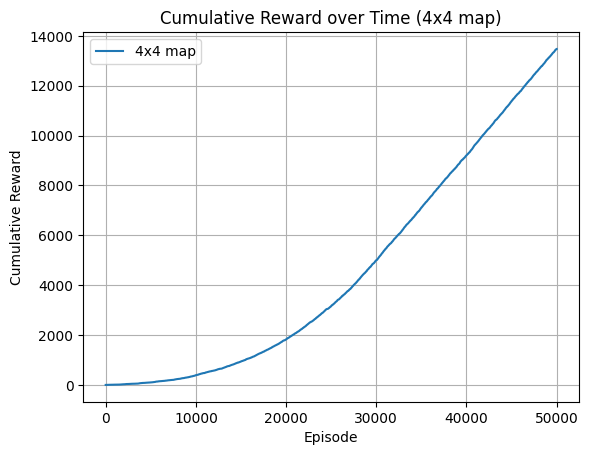

Final Cumulative Reward (4x4 map): 13474.00

6x6 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 58.46%         │
├────────────┼────────────────┤
│ Random     │ 0.10%          │
├────────────┼────────────────┤
│ Heuristic  │ 2.14%          │
╘════════════╧════════════════╛

8x8 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 32.46%         │
├────────────┼────────────────┤
│ Random     │ 0.01%          │
├────────────┼────────────────┤
│ Heuristic  │ 0.25%          │
╘════════════╧════════════════╛

4x4 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 26.95%         │
├────────────┼────────────────┤
│ Random     │ 0.18%          │
├────────────┼────────────────┤
│ Heuristic  │ 0.67%          │
╘════════════╧════════════════╛


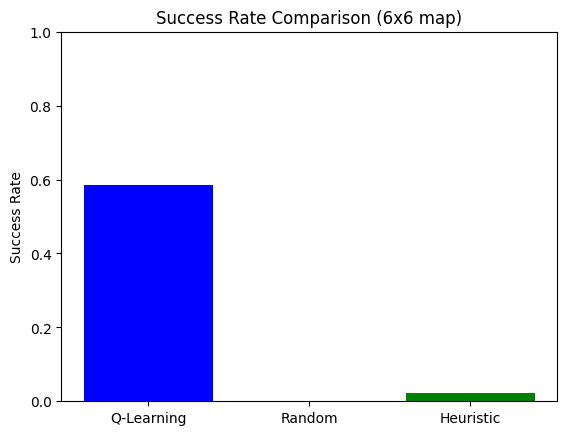

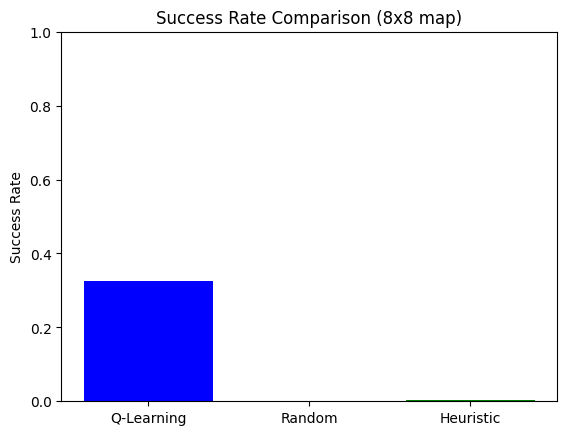

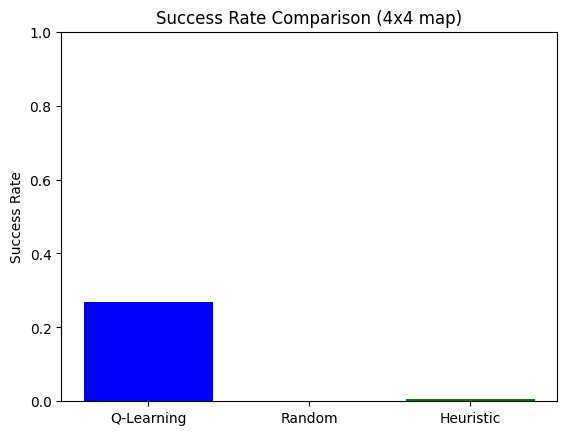

In [171]:
#success rate plot
def plot_success_rate(success_flags, window_size=100, label="6x6", plot=True):
    success_array = np.array(success_flags)
    success_rate = np.convolve(success_array, np.ones(window_size)/window_size, mode='valid')
    if not plot:
        return success_rate
    color = 'blue' if label == "6x6" else 'green' if label == "8x8" else 'orange'
    plt.plot(success_rate, color=color, label=f"{label} map")
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (moving avg)')
    plt.title(f'Success Rate over Time ({label} map, window={window_size})')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    
    print(f"Final Success Rate ({label} map): {success_rate[-1]:.2f}")





# cumulative reward plot
def plot_cumulative_rewards(rewards, window_size=100, label="6x6"):
    rewards_array = np.array(rewards)
    cumulative_rewards = np.cumsum(rewards_array)
    plt.plot(cumulative_rewards, label=f"{label} map")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward over Time ({label} map)')
    plt.grid()
    plt.legend()
    plt.show()

    print(f"Final Cumulative Reward ({label} map): {cumulative_rewards[-1]:.2f}")


# Visualize the learned Q-table as a heatmap
def plot_q_table_heatmap(Q, title="Q-Table Heatmap"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(Q, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show()
# 8x8 Frozen Lake results
plot_success_rate(success_flags, window_size=100, label="8x8")
plot_cumulative_rewards(rewards, window_size=100, label="8x8")
plot_q_table_heatmap(Q_trained, title="Learned Q-Table Heatmap (8x8 Frozen Lake)")

# 6x6 Frozen Lake results
plot_success_rate(success_flags_6x6, window_size=100, label="6x6")
plot_cumulative_rewards(rewards_6x6, window_size=100, label="6x6")
plot_q_table_heatmap(Q_trained_6x6, title="Learned Q-Table Heatmap (6x6 Frozen Lake)")

# 4x4 Frozen Lake results
plot_success_rate(success_flags_4x4, window_size=100, label="4x4")
plot_cumulative_rewards(rewards_4x4, window_size=100, label="4x4")
plot_q_table_heatmap(Q_trained_4x4, title="Learned Q-Table Heatmap (4x4 Frozen Lake)")

# success rate table comparison between 6x6, 8x8, Random and Heuristic
def compare_success_rates(success_flags, success_flags_random, success_flags_heuristic, label="6x6", tablefmt='github'):
    success_rate_Q = np.mean(success_flags)
    success_rate_random = np.mean(success_flags_random)
    success_rate_heuristic = np.mean(success_flags_heuristic)
    data = {
        'Policy': ['Q-Learning', 'Random', 'Heuristic'],
        'Success Rate': [success_rate_Q, success_rate_random, success_rate_heuristic]
    }
    df = pd.DataFrame(data)
    df['Success Rate'] = df['Success Rate'].apply(lambda x: f"{x:.2%}")
    print(f"\n{label} Map - Policy Comparison:")
    print(tabulate(df, headers='keys', tablefmt=tablefmt, showindex=False))


def plot_success_comparison(success_flags_Q, success_flags_random, success_flags_heuristic, label="6x6", policies=['Q-Learning', 'Random', 'Heuristic']):
    success_rate_Q = np.mean(success_flags_Q)
    success_rate_random = np.mean(success_flags_random)
    success_rate_heuristic = np.mean(success_flags_heuristic)
    success_rates = [success_rate_Q, success_rate_random, success_rate_heuristic]
    colors = ['blue', 'red', 'green']
    plt.bar(policies, success_rates, color=colors)
    plt.ylim(0, 1)
    plt.ylabel('Success Rate')
    plt.title(f'Success Rate Comparison ({label} map)')
    plt.show()

compare_success_rates(success_flags_6x6,success_flags_random_6x6, success_flags_heuristic_6x6, label="6x6", tablefmt='fancy_grid')
compare_success_rates(success_flags,success_flags_random_8x8, success_flags_heuristic_8x8, label="8x8", tablefmt='fancy_grid')
compare_success_rates(success_flags_4x4,success_flags_random_4x4, success_flags_heuristic_4x4, label="4x4", tablefmt='fancy_grid')

plot_success_comparison(success_flags_6x6,success_flags_random_6x6, success_flags_heuristic_6x6, label="6x6")
plot_success_comparison(success_flags,success_flags_random_8x8, success_flags_heuristic_8x8, label="8x8")
plot_success_comparison(success_flags_4x4,success_flags_random_4x4, success_flags_heuristic_4x4, label="4x4")

<a class="anchor" id="optimization"></a>
# Optimization

In [172]:
# reliable greedy evaluator
def reliable_greedy_evaluator(env: gym.Env, Q: np.ndarray, num_episodes: int = 1000):
    success_flags = []
    steps_ = []
    for _ in range(num_episodes):
        state, info = env.reset()
        done = False
        steps = 0
        while not done:
            action = np.argmax(Q[state])  # Choose the best action based on Q-values
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            steps += 1
        success_flags.append(1 if done and reward > 0 else 0)
        steps_.append(steps)
            
    return success_flags, steps_


greedy_success_flags_8x8, greedy_steps_8x8 = reliable_greedy_evaluator(env, Q_trained, num_episodes=500)
print(f"Greedy Policy Success Rate (8x8): {np.mean(greedy_success_flags_8x8):.2%}, Average Steps: {np.mean(greedy_steps_8x8):.2f}")



Greedy Policy Success Rate (8x8): 87.40%, Average Steps: 99.32


In [173]:
# try other epsilon decay function
def epsilon_exponential_decay(t, epsilon_initial, epsilon_min, decay):
    '''Exponential decay of epsilon.'''
    return max(epsilon_min,epsilon_initial*(decay**t))

def epsilon_linear_decay(t, total_episodes, epsilon_initial, epsilon_min):
    '''Linear decay of epsilon over 80% of training'''
    stop = int(0.8*total_episodes)
    if t > stop:
        return epsilon_min
    return epsilon_initial -(epsilon_initial-epsilon_min)*(t/stop)

Q_trained_exponential, rewards_exponential, success_flags_exponential = q_learning_training(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.99999, visualize=False, epsilon_scheduling_type='exponential')
Q_trained_linear, rewards_linear, success_flags_linear = q_learning_training(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='linear')

Episode 50000/50000, Total Reward: 1, Epsilon: 0.0500


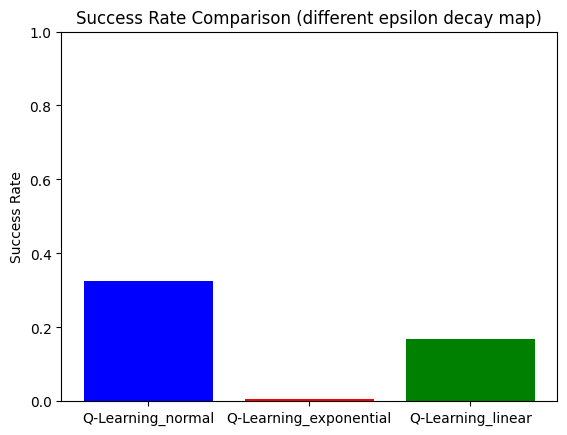

Final Success Rate (normal epsilon decay): 32.46%
Final Success Rate (exponential epsilon decay): 0.70%
Final Success Rate (linear epsilon decay): 16.71%
Greedy Policy Success Rate (exponential epsilon decay): 66.40%, Average Steps: 98.65
Greedy Policy Success Rate (linear epsilon decay): 81.40%, Average Steps: 98.32


In [174]:
# compare results of different epsilon decay functions
plot_success_comparison(success_flags,success_flags_exponential, success_flags_linear, label="different epsilon decay", policies=['Q-Learning_normal', 'Q-Learning_exponential', 'Q-Learning_linear'])
print(f"Final Success Rate (normal epsilon decay): {np.mean(success_flags):.2%}")
print(f"Final Success Rate (exponential epsilon decay): {np.mean(success_flags_exponential):.2%}")
print(f"Final Success Rate (linear epsilon decay): {np.mean(success_flags_linear):.2%}")


greedy_success_flags_linear, greedy_steps_linear = reliable_greedy_evaluator(env, Q_trained_linear, num_episodes=500)
greedy_success_flags_exponential, greedy_steps_exponential = reliable_greedy_evaluator(env, Q_trained_exponential, num_episodes=500)

print(f"Greedy Policy Success Rate (exponential epsilon decay): {np.mean(greedy_success_flags_exponential):.2%}, Average Steps: {np.mean(greedy_steps_exponential):.2f}")
print(f"Greedy Policy Success Rate (linear epsilon decay): {np.mean(greedy_success_flags_linear):.2%}, Average Steps: {np.mean(greedy_steps_linear):.2f}")

In [206]:
# Learning Rate and Discount Factor Tuning
def q_learning_alpha_gamma_tuning(env: gym.Env, alpha_values: list, gamma_values: list, num_episodes: int = 10000):
    results = []
    for alpha in alpha_values:
        for gamma in gamma_values:
            Q, rewards, success_flags = q_learning_training(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False)
            success_rate = np.mean(success_flags)
            results.append((alpha, gamma, success_rate))
            print(f"Alpha: {alpha}, Gamma: {gamma}, Success Rate: {success_rate:.2%}")
    df_results = pd.DataFrame(results, columns=['Alpha', 'Gamma', 'Success Rate'])
    return df_results

# heatmap of tuning results
def plot_tuning_heatmap(df_results):
    pivot_table = df_results.pivot(index='Alpha', columns='Gamma', values='Success Rate')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='YlGnBu')
    plt.title('Q-Learning Alpha and Gamma Tuning Results')
    plt.xlabel('Gamma')
    plt.ylabel('Alpha')
    plt.show()


alpha_values = [
    0.007, 0.009, 0.01, 0.05, 0.1, 0.3, 0.7, 0.9]
gamma_values = [0.8, 0.9, 0.95, 0.99]
tuning_results = q_learning_alpha_gamma_tuning(env, alpha_values, gamma_values, num_episodes=50000)
plot_tuning_heatmap(tuning_results)

Episode 29000/50000, Total Reward: 0, Epsilon: 0.0550


KeyboardInterrupt: 

In [200]:
# reward shaping with everystep penalty -0.01 , hole -10 goal +1
def q_learning_training_with_reward_shaping(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False, epsilon_scheduling_type: str = 'normal', step_penalty: float = -0.01, hole_penalty: float = -10.0, goal_reward: float = 1.0):
    '''Q-learning training with reward shaping.'''
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            next_state, raw_reward, done, truncated, info = env.step(action)
            # Reward shaping
            if done and raw_reward > 0:
                reward = goal_reward  # Goal reached
            elif done and raw_reward == 0:
                reward = hole_penalty  # Fell into a hole
            else:
                reward = step_penalty  # Every step penalty
            # Q-value update
            q_update(Q, state, action,reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and raw_reward > 0 else 0)

        # Decay epsilon
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'exponential':
            epsilon = epsilon_exponential_decay(episode, epsilon_initial, epsilon_min, epsilon_decay)


        # Progress printing
       #if (episode + 1) % 1000 == 0:
        #   print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return Q, rewards, success_flags




In [196]:
# compute Q-learning with reward shaping and compare results without reward shaping
Q_trained_shaped, rewards_shaped, success_flags_shaped = q_learning_training_with_reward_shaping(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')
Q_trained, rewards, success_flags = q_learning_training(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')
#success rate
print(f"Final Success Rate (without reward shaping): {np.mean(success_flags):.2%}")
print(f"Final Success Rate (with reward shaping): {np.mean(success_flags_shaped):.2%}")
# greedy evaluation
greedy_success_flags_no_shaping, greedy_steps_no_shaping = reliable_greedy_evaluator(env, Q_trained, num_episodes=500)
greedy_success_flags_with_shaping, greedy_steps_with_shaping = reliable_greedy_evaluator(env, Q_trained_shaped, num_episodes=500)
print(f"Greedy Policy Success Rate (without reward shaping): {np.mean(greedy_success_flags_no_shaping):.2%}, Average Steps: {np.mean(greedy_steps_no_shaping):.2f}")
print(f"Greedy Policy Success Rate (with reward shaping): {np.mean(greedy_success_flags_with_shaping):.2%}, Average Steps: {np.mean(greedy_steps_with_shaping):.2f}")


Episode 50000/50000, Total Reward: 0, Epsilon: 0.0500
Final Success Rate (without reward shaping): 46.32%
Final Success Rate (with reward shaping): 54.02%
Greedy Policy Success Rate (without reward shaping): 84.00%, Average Steps: 97.89
Greedy Policy Success Rate (with reward shaping): 100.00%, Average Steps: 145.09


In [178]:
# max episode step

In [205]:
# build sweep function for hyperparameter tuning
def hyperparameter_sweep(env: gym.Env, alpha_values: list, gamma_values: list, num_episodes: int = 10000, epsilon_scheduling_types: list = ['normal', 'linear', 'exponential'], step_penalties: list = [-0.01, -0.1], hole_penalties: list = [-1, -10.0, -100.0], goal_rewards: list = [1.0, 10.0, 100.0]):
    results = []
    for alpha, gamma, epsilon_scheduling_type, step_penalty, hole_penalty, goal_reward in itertools.product(alpha_values, gamma_values, epsilon_scheduling_types, step_penalties, hole_penalties, goal_rewards):
        Q, rewards, success_flags = q_learning_training_with_reward_shaping(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type=epsilon_scheduling_type, step_penalty=step_penalty, hole_penalty=hole_penalty, goal_reward=goal_reward)
        success_rate = np.mean(success_flags)
        results.append((alpha, gamma, epsilon_scheduling_type, step_penalty, hole_penalty, goal_reward, success_rate))
        print(f"Alpha: {alpha}, Gamma: {gamma}, Epsilon Decay: {epsilon_scheduling_type}, Step Penalty: {step_penalty}, Hole Penalty: {hole_penalty}, Goal Reward: {goal_reward}, Success Rate: {success_rate:.2%}")
    df_results = pd.DataFrame(results, columns=['Alpha', 'Gamma', 'Epsilon Decay', 'Step Penalty', 'Hole Penalty', 'Goal Reward', 'Success Rate'])
    return df_results
alpha_values = [0.01, 0.05, 0.1]
gamma_values = [0.99, 0.95]
sweep_results = hyperparameter_sweep(env, alpha_values, gamma_values, num_episodes=50000, epsilon_scheduling_types=['normal', 'linear'], step_penalties=[0, -0.01, -0.1], hole_penalties=[0, -1, -10.0], goal_rewards=[1.0, 10.0])
# display top 10 results    
top_10_results = sweep_results.nlargest(10, 'Success Rate')
print("\nTop 10 Hyperparameter Configurations:")
print(tabulate(top_10_results, headers='keys', tablefmt='fancy_grid', showindex=False))



Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: 0, Goal Reward: 1.0, Success Rate: 28.18%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: 0, Goal Reward: 10.0, Success Rate: 35.92%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: -1, Goal Reward: 1.0, Success Rate: 51.21%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: -1, Goal Reward: 10.0, Success Rate: 47.30%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: -10.0, Goal Reward: 1.0, Success Rate: 54.44%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: 0, Hole Penalty: -10.0, Goal Reward: 10.0, Success Rate: 51.38%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: -0.01, Hole Penalty: 0, Goal Reward: 1.0, Success Rate: 0.27%
Alpha: 0.01, Gamma: 0.99, Epsilon Decay: normal, Step Penalty: -0.01, Hole Penalty: 0, Goal Reward: 10.0, Success Rate: 0.38%
Alph

## Test with Algorithmic varients SARSA and Double Q-learning

In [207]:
def sarsa_training(env, num_episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay,
                   visualize=False, epsilon_scheduling_type='normal'):
    n_state, n_actions = env.observation_space.n, env.action_space.n
    Q = np.zeros((n_state, n_actions))
    epsilon_initial = epsilon
    rewards, success_flags = [], []

    for episode in range(num_episodes):
        state, info = env.reset()
        done, episode_reward, success = False, 0.0, 0

        # choose initial action
        action = epsilon_greedy_policy(Q, state, epsilon)

        while not done:
            next_state, raw_reward, done, truncated, info = env.step(action)
            done = done or truncated

            # shaped reward
            if done and raw_reward > 0:
                reward = 1.0; success = 1
            elif done and raw_reward == 0:
                reward = -10.0
            else:
                reward = 0

            # choose next action
            next_action = epsilon_greedy_policy(Q, next_state, epsilon) if not done else None

            # SARSA update
            target = reward if done else (reward + gamma * Q[next_state, next_action])
            Q[state, action] += alpha * (target - Q[state, action])

            state, action = next_state, next_action
            episode_reward += reward

            if visualize:
                env.render()

        rewards.append(episode_reward)
        success_flags.append(success)

        # decay epsilon AFTER episode
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        elif epsilon_scheduling_type == 'exponential':
            epsilon = epsilon_exponential_decay(episode, epsilon_initial, epsilon_min, epsilon_decay)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.4f}")

    return Q, rewards, success_flags


def double_q_learning_training(env, num_episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay,
                               visualize=False, epsilon_scheduling_type='normal'):
    n_state, n_actions = env.observation_space.n, env.action_space.n
    Q1 = np.zeros((n_state, n_actions))
    Q2 = np.zeros((n_state, n_actions))
    epsilon_initial = epsilon
    rewards, success_flags = [], []

    for episode in range(num_episodes):
        state, info = env.reset()
        done, episode_reward, success = False, 0.0, 0

        while not done:
            # ε-greedy policy using combined Q1+Q2
            action = epsilon_greedy_policy(Q1 + Q2, state, epsilon)

            next_state, raw_reward, done, truncated, info = env.step(action)
            done = done or truncated

            # shaped reward
            if done and raw_reward > 0:
                reward = 1.0; success = 1
            elif done and raw_reward == 0:
                reward = -10
            else:
                reward = 0

            # randomly update one of the Q-tables
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(Q1[next_state])
                target = reward if done else reward + gamma * Q2[next_state, best_next_action]
                Q1[state, action] += alpha * (target - Q1[state, action])
            else:
                best_next_action = np.argmax(Q2[next_state])
                target = reward if done else reward + gamma * Q1[next_state, best_next_action]
                Q2[state, action] += alpha * (target - Q2[state, action])

            state = next_state
            episode_reward += reward

            if visualize:
                env.render()

        rewards.append(episode_reward)
        success_flags.append(success)

        # decay epsilon AFTER episode
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        elif epsilon_scheduling_type == 'exponential':
            epsilon = epsilon_exponential_decay(episode, epsilon_initial, epsilon_min, epsilon_decay)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.4f}")

    return Q1 + Q2, rewards, success_flags

    


In [209]:
Q_trained_sarsa, rewards_sarsa, success_flags_sarsa = sarsa_training(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')



Q_trained_double, rewards_double, success_flags_double = double_q_learning_training(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')

print(f"Final Success Rate (SARSA): {np.mean(success_flags_sarsa):.2%}")
print(f"Final Success Rate (Double Q-Learning): {np.mean(success_flags_double):.2%}")
print(f"Final Success Rate (Q-Learning with Reward Shaping): {np.mean(success_flags_shaped):.2%}")


Episode 1000/50000, Reward: -10.00, Epsilon: 0.9048
Episode 2000/50000, Reward: -10.00, Epsilon: 0.8187
Episode 3000/50000, Reward: -10.00, Epsilon: 0.7408
Episode 4000/50000, Reward: -10.00, Epsilon: 0.6703
Episode 5000/50000, Reward: -10.00, Epsilon: 0.6065
Episode 6000/50000, Reward: -10.00, Epsilon: 0.5488
Episode 7000/50000, Reward: -10.00, Epsilon: 0.4966
Episode 8000/50000, Reward: -10.00, Epsilon: 0.4493
Episode 9000/50000, Reward: -10.00, Epsilon: 0.4066
Episode 10000/50000, Reward: -10.00, Epsilon: 0.3679
Episode 11000/50000, Reward: -10.00, Epsilon: 0.3329
Episode 12000/50000, Reward: -10.00, Epsilon: 0.3012
Episode 13000/50000, Reward: -10.00, Epsilon: 0.2725
Episode 14000/50000, Reward: -10.00, Epsilon: 0.2466
Episode 15000/50000, Reward: -10.00, Epsilon: 0.2231
Episode 16000/50000, Reward: -10.00, Epsilon: 0.2019
Episode 17000/50000, Reward: 1.00, Epsilon: 0.1827
Episode 18000/50000, Reward: -10.00, Epsilon: 0.1653
Episode 19000/50000, Reward: 1.00, Epsilon: 0.1496
Episod